# DETECTION DE FRAUDE, «GAMING»

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OneHotEncoder
import pickle
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('lambtech2024ia _dataset.csv')

In [3]:
df.sample(10)

,Montant,Type,Timestamp,Origine,Destination
23269,1025.0,CASHIN,2018-08-03 13:09:00,3392221776747,8843
22693,80.0,PAYMENT,2018-08-02 16:28:45,45370,339287428176
41990,16019.0,PAYMENT,2019-01-29 20:26:23,33924733336,33924613588
44141,34184.0,PAYMENT,2019-11-18 23:47:33,33924156613,33924317352
26529,87000.0,CASHOUT,2018-08-06 15:01:12,339263814182,3392246357837
44581,29870.0,PAYMENT,2018-03-01 21:48:19,33924953321,33924533034
25785,5025.0,P2P,2018-08-06 12:44:34,339228489533,339229251760
16320,2100.0,P2P,2018-07-22 20:46:40,339227139283,339248139779
821,5300.0,PAYMENT,2018-06-19 22:08:02,339226952109,339339931
35622,1000.0,CASHIN,2018-08-16 20:02:34,33926303980079,339227940989


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46774 entries, 0 to 46773
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Montant      46774 non-null  float64
 1   Type         46774 non-null  object 
 2   Timestamp    45861 non-null  object 
 3   Origine      46774 non-null  object 
 4   Destination  46774 non-null  int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 1.8+ MB


## Exploration et ingenierie de données

In [5]:
df.dropna()
df = df[df['Origine'] != 'Wallet Appro Sous Distributeurs']

In [6]:
df['Destination'] = df['Destination'].astype(object)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.describe() 

,Montant,Timestamp
count,4.675000e+04,45837
mean,6.299059e+04,2018-08-28 18:49:29.380936704
min,1.000000e+00,2018-01-01 00:26:35
25%,2.000000e+03,2018-07-11 09:31:49
50%,1.721650e+04,2018-07-30 15:58:28
75%,4.555150e+04,2018-08-13 23:16:30
max,1.500000e+07,2019-12-30 23:24:19
std,2.776956e+05,NaN


In [7]:
df['Type'].value_counts()

Type
CASHIN     15734
CASHOUT    13697
P2P         8749
PAYMENT     8570
Name: count, dtype: int64

On a 4 types de transaction :
* CASHIN
* CASHOUT
* P2P
* PAYMENT

([<matplotlib.patches.Wedge at 0x12b842770>,
 [Text(0.5403268691294005, 0.9581476266718087, 'CASHIN'),
  Text(-1.093766269884009, 0.11694163870932212, 'CASHOUT'),
  Text(-0.18495187527639828, -1.084339800907328, 'P2P'),
  Text(0.9225710747398777, -0.5990514268852946, 'PAYMENT')],
 [Text(0.2947237467978548, 0.5226259781846229, '33.7%'),
  Text(-0.5965997835730957, 0.06378634838690296, '29.3%'),
  Text(-0.10088284105985361, -0.5914580732221788, '18.7%'),
  Text(0.5032205862217514, -0.32675532375561517, '18.3%')])

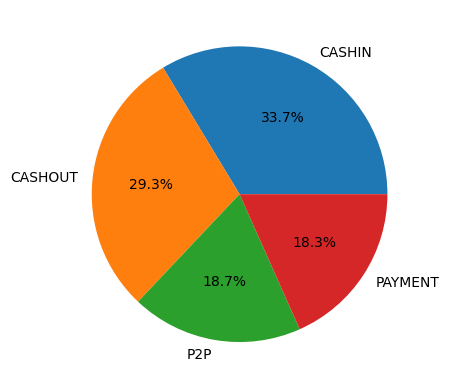

In [8]:
labels = ['CASHIN','CASHOUT', 'P2P', 'PAYMENT']
fig, ax = plt.subplots()
ax.pie(df['Type'].value_counts(),labels=labels, autopct='%1.1f%%')

In [9]:
pd.DataFrame({'data_P2P': df.loc[df["Type"] == 'P2P'].shape, 'data_CASHOUT' : df.loc[df["Type"] == 'CASHOUT'].shape, 'data_CASHIN' : df.loc[df["Type"] == 'CASHIN'].shape, 'data_PAYMENT' : df.loc[df["Type"] == 'PAYMENT'].shape}, index=['nb_row', 'nb_feature'])

,data_P2P,data_CASHOUT,data_CASHIN,data_PAYMENT
nb_row,8749,13697,15734,8570
nb_feature,5,5,5,5


In [10]:
# # fonctionnalités temporelles
# df['year'] = df['Timestamp'].dt.year
# df['month'] = df['Timestamp'].dt.month
# df['day'] = df['Timestamp'].dt.day
# df['dayofweek'] = df['Timestamp'].dt.dayofweek
df['hour'] = df['Timestamp'].dt.hour
# df['minute'] = df['Timestamp'].dt.minute


In [11]:
def intersection(lst1, lst2):
     
    return [item for item in lst1 if item in lst2]

origine = df['Origine'].tolist()
destination = df['Destination'].tolist()
intersection(origine, destination)

[]

Il n'y a donc pas d'origine qui se repete dans la destination

In [12]:
df['Type'].value_counts()

Type
CASHIN     15734
CASHOUT    13697
P2P         8749
PAYMENT     8570
Name: count, dtype: int64

### Seulement les transactions auprès de distributeurs nous interessent

In [13]:
df_cash = df[df['Type'].isin(["CASHOUT", "CASHIN"])]
df_cash.sample(5)

,Montant,Type,Timestamp,Origine,Destination,hour
28651,24000.0,CASHOUT,2018-08-09 17:57:32,33922494764473,33922494764475,17.0
20134,1000.0,CASHIN,2018-07-30 13:07:01,3392236939007,29940,13.0
11936,4500.0,CASHOUT,2018-07-15 15:12:13,339224247971,33922781220879,15.0
19500,10000.0,CASHIN,2018-07-28 23:38:58,3392464848767,339268992721,23.0
12948,25000.0,CASHIN,2018-07-16 18:08:52,3392217919917,339221791991,18.0


Je determine la durée pour chaque personne depuis sa dernière transaction.

In [14]:
df_cash['time_diff'] = df_cash.groupby('Origine')['Timestamp'].diff()
df_cash['time_diff'] = df_cash['time_diff']
df_cash.head(7)

,Montant,Type,Timestamp,Origine,Destination,hour,time_diff
125,100.0,CASHIN,2018-06-14 22:17:53,33922832723899,3396555559,22.0,NaT
200,405450.0,CASHIN,2018-06-15 17:30:21,339229662095,339353159,17.0,NaT
201,1.0,CASHIN,2018-06-15 17:31:54,339057238,339353153,17.0,NaT
205,47000.0,CASHIN,2018-06-15 17:56:21,339264382557,339353153,17.0,NaT
206,726400.0,CASHIN,2018-06-15 17:57:20,339264382557,339353159,17.0,0 days 00:00:59
207,772900.0,CASHIN,2018-06-15 18:00:02,339264382531,339353159,18.0,NaT
209,459750.0,CASHIN,2018-06-15 18:01:13,339264382531,339353153,18.0,0 days 00:01:11


Je me permet de suspecter les personnes qui effectuent un certain nombre de transaction pendant la meme heure, puis je calcule le temps median pour chaque personne entre ses transactions.

### Soupçons

In [15]:
# Compter le nombre de transactions pour chaque heure et chaque origine
hourly_transactions_by_origin = df_cash.groupby(['Origine', 'hour']).size().reset_index(name='transaction_count')

# Calculer le nombre moyen de transactions par heure pour chaque origine
average_nb_per_hour = hourly_transactions_by_origin.groupby('Origine')['transaction_count'].mean().reset_index(name='average_transaction_count')

df_suspects_ori = average_nb_per_hour[average_nb_per_hour['average_transaction_count'] > np.median(average_nb_per_hour['average_transaction_count'])]

data = df_cash.merge(df_suspects_ori, on='Origine', how='left')
suspects = data[data['average_transaction_count'] >= np.mean(data['average_transaction_count'])]
data

,Montant,Type,Timestamp,Origine,Destination,hour,time_diff,average_transaction_count
0,100.0,CASHIN,2018-06-14 22:17:53,33922832723899,3396555559,22.0,NaT,NaN
1,405450.0,CASHIN,2018-06-15 17:30:21,339229662095,339353159,17.0,NaT,4.111111
2,1.0,CASHIN,2018-06-15 17:31:54,339057238,339353153,17.0,NaT,NaN
3,47000.0,CASHIN,2018-06-15 17:56:21,339264382557,339353153,17.0,NaT,8.214286
4,726400.0,CASHIN,2018-06-15 17:57:20,339264382557,339353159,17.0,0 days 00:00:59,8.214286
...,...,...,...,...,...,...,...,...
29426,60.0,CASHIN,2018-08-18 23:07:57,339855833,339258137224,23.0,0 days 00:06:39,6.500000
29427,10000.0,CASHOUT,2018-08-18 23:09:25,339258137224,3392670400737,23.0,0 days 05:58:59,1.666667
29428,1000.0,CASHIN,2018-08-18 23:10:26,3392263524077,339224562012,23.0,6 days 04:05:20,1.857143
29429,42000.0,CASHOUT,2018-08-18 23:20:54,339246337975,3392278096017,23.0,14 days 20:53:48,NaN


In [16]:
# time_threshold = pd.Timedelta(hours=1)

# # Filtrer les utilisateurs avec des transactions rapprochées
# df_suspects_ori = df_cash[df_cash['time_diff'] < time_threshold]

# # nombre moyen de transaction pour chaque utilisateur par heure 
# mean_transaction_per_hour = df_suspects_ori.groupby(['Origine'])['Montant'].mean().reset_index()
# mean_transaction_per_hour.columns = ['Origine', 'mean_transaction_per_hour']
# suspects = df_suspects_ori[['Origine']].merge(mean_transaction_per_hour, on='Origine', how='left')
# suspects = suspects[suspects['mean_transaction_per_hour'] >= np.median(suspects['mean_transaction_per_hour'])]
# suspects

In [17]:
suspects_list = suspects["Origine"].tolist()
print('Pourcentage de suspect: ', len(set(suspects_list))/df_cash['Origine'].unique().shape[0])

Pourcentage de suspect:  0.002243549794341269


Une personne sera alors considerer comme suspecte si elle est dans la liste precedement determinée.

In [18]:
# difference moyenne de temps par origine entre transactions

median_time_diff_per_origin = df_cash.groupby('Origine')['time_diff'].mean().reset_index()
median_time_diff_per_origin.columns = ['Origine', 'median_time_diff']
data = data.merge(median_time_diff_per_origin, on='Origine', how='left')
data['time_diff'] = data['time_diff'].dt.total_seconds() / 60
data['median_time_diff'] = data['median_time_diff'].dt.total_seconds() / 60

df_suspects_ori = data[data['median_time_diff'] < np.mean(data['median_time_diff'])]

suspects2 = df_suspects_ori[['Origine']].merge(average_nb_per_hour, on='Origine', how='left')
suspects2 = df_suspects_ori[df_suspects_ori['median_time_diff'] >= np.median(df_suspects_ori['median_time_diff'])]
suspects2

,Montant,Type,Timestamp,Origine,Destination,hour,time_diff,average_transaction_count,median_time_diff
1,405450.0,CASHIN,2018-06-15 17:30:21,339229662095,339353159,17.0,NaN,4.111111,2468.944907
12,444000.0,CASHIN,2018-06-15 18:13:39,339264942783,339353159,18.0,NaN,4.000000,2313.514957
19,219300.0,CASHIN,2018-06-15 18:32:56,339264382505,339353159,18.0,NaN,4.615385,1530.566384
22,355800.0,CASHIN,2018-06-15 18:36:01,339264382505,339353159,18.0,3.083333,4.615385,1530.566384
23,245050.0,CASHIN,2018-06-15 18:37:06,339264382505,339353159,18.0,1.083333,4.615385,1530.566384
...,...,...,...,...,...,...,...,...,...
29413,1300.0,CASHOUT,2018-08-18 21:30:54,26209,3392241222587,21.0,2043.350000,NaN,2043.350000
29419,1500.0,CASHIN,2018-08-18 22:43:12,3392695779737,339222755335,22.0,1680.133333,2.000000,969.888889
29421,1000.0,CASHIN,2018-08-18 22:43:59,3392695779737,339221424651,22.0,0.783333,2.000000,969.888889
29427,10000.0,CASHOUT,2018-08-18 23:09:25,339258137224,3392670400737,23.0,358.983333,1.666667,6393.972222


In [19]:
suspects_list2 = suspects2["Origine"].tolist()
print('Pourcentage de suspect (basant sur le temps): ', suspects2['Origine'].unique().shape[0]/df_cash['Origine'].unique().shape[0])

Pourcentage de suspect (basant sur le temps):  0.13374049607378785


In [20]:
data

,Montant,Type,Timestamp,Origine,Destination,hour,time_diff,average_transaction_count,median_time_diff
0,100.0,CASHIN,2018-06-14 22:17:53,33922832723899,3396555559,22.0,NaN,NaN,NaN
1,405450.0,CASHIN,2018-06-15 17:30:21,339229662095,339353159,17.0,NaN,4.111111,2468.944907
2,1.0,CASHIN,2018-06-15 17:31:54,339057238,339353153,17.0,NaN,NaN,NaN
3,47000.0,CASHIN,2018-06-15 17:56:21,339264382557,339353153,17.0,NaN,8.214286,778.742544
4,726400.0,CASHIN,2018-06-15 17:57:20,339264382557,339353159,17.0,0.983333,8.214286,778.742544
...,...,...,...,...,...,...,...,...,...
29426,60.0,CASHIN,2018-08-18 23:07:57,339855833,339258137224,23.0,6.650000,6.500000,566.525758
29427,10000.0,CASHOUT,2018-08-18 23:09:25,339258137224,3392670400737,23.0,358.983333,1.666667,6393.972222
29428,1000.0,CASHIN,2018-08-18 23:10:26,3392263524077,339224562012,23.0,8885.333333,1.857143,2927.398611
29429,42000.0,CASHOUT,2018-08-18 23:20:54,339246337975,3392278096017,23.0,21413.800000,NaN,21413.800000


In [21]:
transaction_count_per_origin = df_cash.groupby('Origine').size().reset_index(name='transaction_count')
data = data.merge(transaction_count_per_origin, on='Origine', how='left')
data

,Montant,Type,Timestamp,Origine,Destination,hour,time_diff,average_transaction_count,median_time_diff,transaction_count
0,100.0,CASHIN,2018-06-14 22:17:53,33922832723899,3396555559,22.0,NaN,NaN,NaN,1
1,405450.0,CASHIN,2018-06-15 17:30:21,339229662095,339353159,17.0,NaN,4.111111,2468.944907,37
2,1.0,CASHIN,2018-06-15 17:31:54,339057238,339353153,17.0,NaN,NaN,NaN,1
3,47000.0,CASHIN,2018-06-15 17:56:21,339264382557,339353153,17.0,NaN,8.214286,778.742544,115
4,726400.0,CASHIN,2018-06-15 17:57:20,339264382557,339353159,17.0,0.983333,8.214286,778.742544,115
...,...,...,...,...,...,...,...,...,...,...
29426,60.0,CASHIN,2018-08-18 23:07:57,339855833,339258137224,23.0,6.650000,6.500000,566.525758,78
29427,10000.0,CASHOUT,2018-08-18 23:09:25,339258137224,3392670400737,23.0,358.983333,1.666667,6393.972222,7
29428,1000.0,CASHIN,2018-08-18 23:10:26,3392263524077,339224562012,23.0,8885.333333,1.857143,2927.398611,13
29429,42000.0,CASHOUT,2018-08-18 23:20:54,339246337975,3392278096017,23.0,21413.800000,NaN,21413.800000,2


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29431 entries, 0 to 29430
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Montant                    29431 non-null  float64       
 1   Type                       29431 non-null  object        
 2   Timestamp                  28518 non-null  datetime64[ns]
 3   Origine                    29431 non-null  object        
 4   Destination                29431 non-null  object        
 5   hour                       28518 non-null  float64       
 6   time_diff                  20253 non-null  float64       
 7   average_transaction_count  19373 non-null  float64       
 8   median_time_diff           24869 non-null  float64       
 9   transaction_count          29431 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(1), object(3)
memory usage: 2.2+ MB


In [23]:
def intersection(lst1, lst2):
     
    return [item for item in lst1 if item in lst2]

origine = suspects_list
destination = suspects_list2
intersection(origine, destination)

[]

## Isolation des cas suspects grace a l'algorithme de ML et creation du modele

In [24]:

encoder = OneHotEncoder(handle_unknown='ignore')
encod_Type = pd.get_dummies(data['Type'])
data = pd.concat([data, encod_Type], axis=1)
data = data.drop(['Type'], axis = 1)

features = ['Montant','hour', 'time_diff', 'average_transaction_count', 'median_time_diff', 'transaction_count', 'CASHIN', 'CASHOUT']
# data = data[features]
data = data.fillna(0)
# print(X.columns)
    
# X = X.merge(data_type, axis=1)
    
# Entraînement du modèle Isolation Forest
model = IsolationForest(contamination=0.15 )  # 15% des données sont considérées comme anomalies
model.fit(data[features])


# import pickle
# with open('Isolateur.pkl', 'w') as f:
#     f.dump(model, f)

# Prédiction des anomalies
data['Fraude'] = model.predict(data[features])
data['Fraude'] = data['Fraude'].apply(lambda x: 1 if x == -1 else 0)


# fraude = data[['Origine', 'Destination', 'Fraude']]
# fraude.to_csv('Predictions.csv')


In [25]:
rl =  LogisticRegression()
rl.fit(data[['Montant','hour', 'time_diff', 'average_transaction_count', 'median_time_diff', 'transaction_count', 'CASHIN', 'CASHOUT']],data['Fraude'])
with open('model_de_prediction.pkl', 'wb') as f:
    pickle.dump(rl, f)

## Verification des hypothèses

In [26]:
check = data[data['Fraude'] == 1]

In [27]:
fnd = check['Origine'].to_list()

In [28]:
len(intersection(fnd, suspects_list))

1422

In [29]:
check = data[data['Fraude'] == 1]
fnd = check['Origine'].to_list()
len(intersection(fnd, suspects_list))

print('Cas suspects avéré:', len(intersection(fnd, suspects_list)))
print('Pourcentage sur critère 1:', len(check)/len(suspects_list))
print('Pourcentage sur critère 2:', len(check)/len(suspects_list2))

Cas suspects avéré: 1422
Pourcentage sur critère 1: 0.8291079812206573
Pourcentage sur critère 2: 0.47259687433097836


In [30]:
data['Fraude'].value_counts()

Fraude
0    25016
1     4415
Name: count, dtype: int64

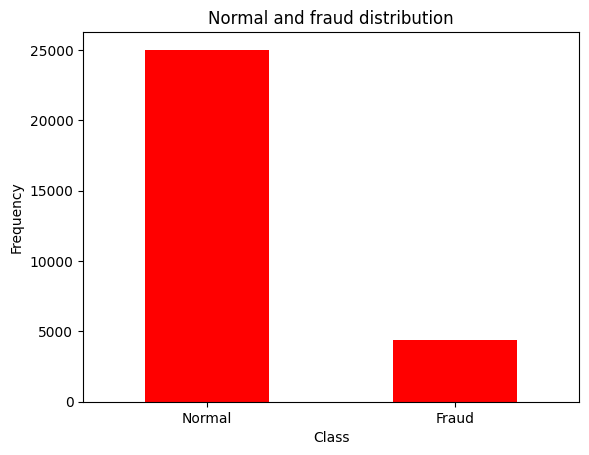

In [31]:
fraud_check = pd.value_counts(data['Fraude'], sort =True)
fraud_check.plot(kind = 'bar', rot=0, color='r')
plt.title("Normal and fraud distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")
Labels = ['Normal','Fraud']
plt.xticks(range(2), Labels)
plt.show()

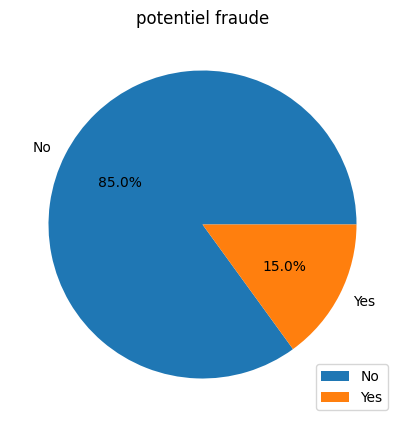

In [32]:
y=pd.value_counts(data['Fraude'], sort =True)
plt.figure(figsize=(5,5))
labels=['No','Yes']
plt.pie(y,labels=labels,autopct='%1.1f%%')
plt.legend(loc='lower right')
plt.title('potentiel fraude')
plt.show()

## Notre API

In [33]:
import gradio as gr

with open('model_de_prediction.pkl', 'rb') as f:
    model = pickle.load(f)

def predict_fraud(filepath):
    # df_test = pd.read_csv(filepath.name)
    from entrainement_et_generation_model import GENERATE_FRAUDES
    df_generated = GENERATE_FRAUDES(filepath.name)

    features = ['Montant','hour', 'time_diff', 'average_transaction_count', 'median_time_diff', 'transaction_count', 'CASHIN', 'CASHOUT']
    X_test = df_generated[features]

    # Make predictions
    predictions = model.predict(X_test)

    # Add predictions to the DataFrame
    df_generated['Fraude'] = predictions

    # Return relevant columns including the predictions
    return df_generated[['Origine', 'Destination','Fraude']]

# Create the Gradio interface
iface = gr.Interface(
    fn=predict_fraud,
    inputs=[
        gr.File(label="Upload CSV file")
    ],
    outputs=gr.Dataframe(),
    title="Fraud Detection in Fintech",
    description="Upload a CSV file with transaction details to check for fraudulent transactions."
)

# Launch the interface
if __name__ == "__main__":
    iface.launch()


Running on local URL:  http://127.0.0.1:7861

To create a public link, set `share=True` in `launch()`.
